# Tutorial: Gene annotation comparison

In this example, we compare different gene annotation sets:

* In Part 1, we compare two human gene annotation sets, namely gencode (v39) and chess (v3.0.1).
* In Part 2, we compare two fly miRNA annotation sets: MirGenDB (v2.0) and flybase (v6.55)

## Requirements
Before executing this notebook, you need to install all required *rnalib* requirements as well as optional libraries needed by this notebook.
It is recommended to do this in a [Python virtual environment](https://rnalib.readthedocs.io/en/latest/readme.html#installation).

This notebook as well as *rnalib*'s testing suite use various **test resources** (genomics data files and indexing structures) that can either be downloaded from the Github repository or 
created by running the *rnalib* `rnalib_create_testdata` script. Please refer to [the rnalib documentation](https://rnalib.readthedocs.io/en/latest/readme.html#test-data) for detailed instructions.
There are two separate test resource sets:

* *test_resources*: small test datasets that are used by *rnalib*'s test suite
* *large_test_resources*: larger test files that are needed to demonstrate *rnalib* under realistic conditions. 

*Rnalib* knows about the location of the test data via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by 'monkeypatching' (rna.__RNALIB_TESTDATA__ = ...) as shown below. Once this is done, test data resources can be accessed via `rna.get_resource(<resource_id>)`. *Rnalib* will recreate these resources only if they are not found in the configured output folder.

In [1]:
import os, pathlib, platform
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import traceback
import math
from tqdm.auto import tqdm

# load rnalib
import rnalib as rna
from rnalib import gi, GI, SEP, display_textarea
display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

# ensure test data
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/" # monkeypatch test data dir
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, (rna.testdata.test_resources,rna.testdata.large_test_resources)) # requires additional tools installed
display(f"Testdata in {rna.__RNALIB_TESTDATA__}")
display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Running rnalib 0.0.3 on python 3.12.1'

Creating testdata:   0%|          | 0/46 [00:00<?, ?it/s]

Creating testdata:   0%|          | 0/11 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


'Testdata in rnalib_testdata/'

## Part 1: compare gencode and chess annotations

Here, we compare two human gene annotation sets: gencode (v39) and chess (v3.0.1).
We load all protein_coding genes from both annotation sets, update the gene-names to their latest given symbol (using gennames.org data) and
compare both sets.  We then exemplary show how to further analyze differences between those gene annotations.

First, we load gencode and chess annotation data and build the respective transcriptomes (takes about 4min).
We configure a transcript filter that includes only entries with gene_type 'protein_coding' and restrict this analysis to all canonical GRCh38 chromsomes (i.e., chr1-22,X,Y,M).
To update to the latest gene symbols, we use genenames.org data and configure via the 'gene_name_alias_file' property. rnalib automatically updates gene names accordingly. 


In [2]:
alias_txt=rna.get_resource("gene_aliases") # gene name aliases
gencode_gff=rna.get_resource("full_gencode_gff") # Gencode data
chess_gff=rna.get_resource("full_chess_gtf") # Chess data

txfilter = rna.TranscriptFilter(). \
    include_gene_types({'protein_coding'}). \
    include_chromosomes(rna.CANONICAL_CHROMOSOMES['GRCh38'])

t_gc=rna.Transcriptome(
    annotation_gff = gencode_gff,
    annotation_flavour ='gencode',
    copied_fields =['gene_type', 'transcript_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

# NOTE: in chess, there is no 'transcript_type' annotation
t_ch=rna.Transcriptome(
    annotation_gff = chess_gff,
    annotation_flavour ='chess',
    copied_fields =['gene_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

# compare
display(SEP)
display(t_gc)
display(t_ch)

load gene aliases:   0%|          | 0/43842 [00:00<?, ?it/s]

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/19982 [00:00<?, ?it/s]

load gene aliases:   0%|          | 0/43842 [00:00<?, ?it/s]

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

/Users/niko/projects/rnalib/rnalib/__init__.py:1124: UserWarning: Gene CHS.40038 has tx with incompatible coordinates! chr4:22692937-22819569 (+) vs chr4:22727294-22728023 (-), skipping tx CHS.40038.9
  warnings.warn(
/Users/niko/projects/rnalib/rnalib/__init__.py:1124: UserWarning: Gene CHS.43075 has tx with incompatible coordinates! chr5:69631756-69636953 (+) vs chr5:69639463-69710527 (-), skipping tx CHS.43075.3
  warnings.warn(
/Users/niko/projects/rnalib/rnalib/__init__.py:1124: UserWarning: Gene CHS.45631 has tx with incompatible coordinates! chr6:25081067-25138392 (-) vs chr6:25139664-25141641 (+), skipping tx CHS.45631.10
  warnings.warn(


Build interval trees:   0%|          | 0/58284 [00:00<?, ?it/s]

---

Transcriptome with 19982 genes and 164578 tx

Transcriptome with 58284 genes and 158063 tx

Please note that, the numbers reported in the [Chess3 paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03088-4/) differ, particularly in the number of protein_coding gencode transcripts:

| Database    | Number of protein-coding gene loci | Number of protein-coding transcripts | Number of distinct protein sequences | Number of gene loci (all types) |
|-------------|------------------------------------|--------------------------------------|--------------------------------------|---------------------------------|
| CHESS v3    | 19,839                             | 99,202                               | 73,767                               | 41,356                          |
| RefSeq v110 | 19,884                             | 129,740                              | 88,662                               | 43,380                          |
| GENCODE v41 | 19,419                             | 110,309                              | 92,968                               | 46,181                          |

*Table 1 from the [CHESS3 paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03088-4/tables/1): Total number of genes and protein-coding isoforms in current versions of CHESS, RefSeq, and GENCODE. Genes are counted on the primary chromosomes and unplaced scaffolds from the human reference genome GRCh38, excluding the alternative scaffolds. Pseudogenes, VDJ segments, and C regions are not included in the totals shown in the final column.*

This can partially be explained by the different chromosome sets used (we include only primary chromosomes).

Now we can have a look at the shared and unique (normalized) gene names and
display the unique gene names for genocde and chess.

In [3]:
# cmp_sets is a rnalib utility function for set comparison
shared, uniq_gc, uniq_ch = rna.cmp_sets({x.gene_name for x in t_gc.genes}, 
                                        {x.gene_name for x in t_ch.genes}) 
display(f"Unique gene names in gencode: {len(shared)+len(uniq_gc)}, in chess: {len(shared)+len(uniq_ch)}")
display(f"Shared: {len(shared)}, only in gencode: {len(uniq_gc)}, only in chess: {len(uniq_ch)}")
display_textarea(f"Unique in gencode: {uniq_gc}")
display_textarea(f"Unique in chess: {uniq_ch}")

'Unique gene names in gencode: 19955, in chess: 58215'

'Shared: 19346, only in gencode: 609, only in chess: 38869'

As expected, most genes are annotated in both sets as expected but there are some unique entries too.
Most unique genecode genes have no given name but an ensembl gene id (starting with ENSG), 
while most unique chess genes start with “LOC” which indicates unknown function.
Let's have a look at 'ELOA3CP', a pseudogene which is only annotated in gencode 
(https://www.genecards.org/cgi-bin/carddisp.pl?gene=ELOA3CP). We query the chess annotation set for the gencode gene coordinates:

In [4]:
gid="ELOA3CP"
display(f"In Gencode, {gid} is annotated at {t_gc[gid].location}")
display("In Gencode at this region:", [(x.location, x.gene_name, x.strand) for x in t_gc.query(t_gc[gid], feature_types=['gene'])])
display("In Chess at this region:",   [(x.location, x.gene_name, x.strand) for x in t_ch.query(t_gc[gid], feature_types=['gene'])])

'In Gencode, ELOA3CP is annotated at chr18:46968695-46969912 (-)'

'In Gencode at this region:'

[(chr18:46917492-47103478 (+), 'KATNAL2', '+'),
 (chr18:46968695-46969912 (-), 'ELOA3CP', '-')]

'In Chess at this region:'

[(chr18:46917594-47103478 (+), 'KATNAL2', '+')]

Indeed, it shows only the overlapping KATNAL2 gene on the opposite strand.
Vice versa, we look at 'MMP24-AS1-EDEM2' which is found only in the chess annotation

In [5]:
display(f"In Chess, MMP24-AS1-EDEM2 is annotated at {t_ch.gene['MMP24-AS1-EDEM2'].location}")
display("In Gencode at this region:", [(x.location, x.gene_name, x.strand) for x in t_gc.query(t_ch['MMP24-AS1-EDEM2'], feature_types=['gene'])])
display("In Chess at this region:",   [(x.location, x.gene_name, x.strand) for x in t_ch.query(t_ch['MMP24-AS1-EDEM2'], feature_types=['gene'])])

'In Chess, MMP24-AS1-EDEM2 is annotated at chr20:35115364-35278122 (-)'

'In Gencode at this region:'

[(chr20:35115364-35147336 (-), 'EDEM2', '-'),
 (chr20:35172072-35216240 (+), 'PROCR', '+'),
 (chr20:35201745-35278131 (-), 'MMP24OS', '-'),
 (chr20:35226690-35276998 (+), 'MMP24', '+'),
 (chr20:35267885-35280043 (-), 'ENSG00000261582', '-')]

'In Chess at this region:'

[(chr20:35115364-35147336 (-), 'EDEM2', '-'),
 (chr20:35115364-35278122 (-), 'MMP24-AS1-EDEM2', '-'),
 (chr20:35117136-35117207 (-), 'LOC124900460', '-'),
 (chr20:35171096-35216240 (+), 'PROCR', '+'),
 (chr20:35195306-35195423 (+), 'RNA5SP483', '+'),
 (chr20:35218009-35218185 (+), 'MT1P3', '+'),
 (chr20:35226690-35276998 (+), 'MMP24', '+'),
 (chr20:35276352-35278122 (-), 'MMP24OS', '-')]

Note that not all gene names in a transcriptome are unique. For example, genes in pseudo-autosomal 
regions (PAR), such as WASH6P, are annotated at different genomic locations (e.g., X and Y chromosomes)
with the same gene_name but different feature IDs. rnalib properly handles such
genes and maintains a dict that maps duplicate gene_names to the respective gene objects:

In [6]:
display_textarea(f"Duplicate gene names in gencode: {t_gc.duplicate_gene_names}") 
display_textarea(f"Duplicate gene names in chess:   {t_ch.duplicate_gene_names}")

For a more detailed analysis, we iterate all gencode genes and overlap with chess annotations 
using rnalib's annotation iterator. 
We count some stats and select the chess annotation with the highest overlap for a gene-to-gene comparison.
Finally, we calculate a histogram of absolute difference between gencode and chess annotations for start and end 
coordinates and plot the first 50 values in a barplot

  0%|          | 0/25 [00:00<?, ?it/s]

Counter({'gencode_genes': 19982,
         'differing_location': 11804,
         'differing_gene_name': 611,
         'differing_gene_name_uniq': 608,
         'gencode_genes_no_match': 1})

{'differing_location_example': 'gc: chrY:57184216-57197337 (+), ch: {gene@chrY:57184129-57197869}',
 'differing_gene_name_example': "gc: WASH6P, ch: ['CHS.139250', 'WASH6P_1', 'DDX11L16']"}

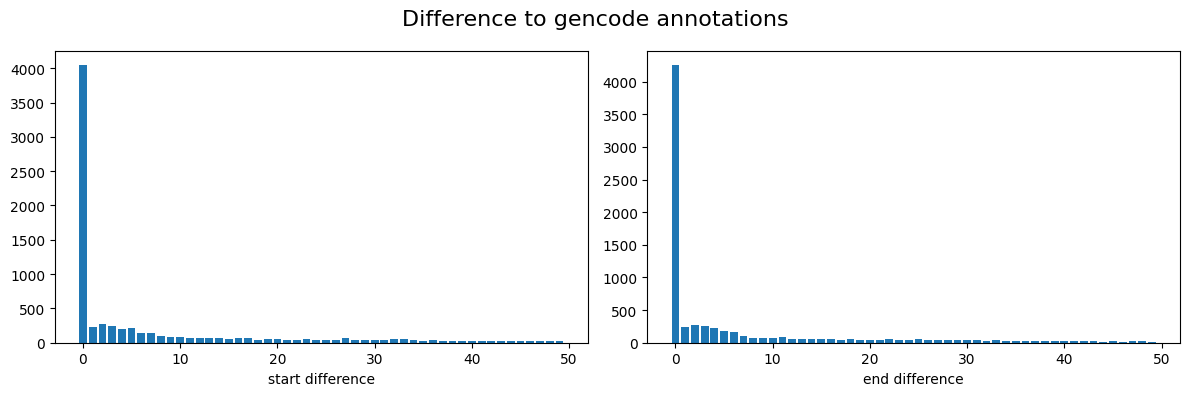

In [7]:
stats=Counter()
examples=dict()
hist_start, hist_end=Counter(), Counter()
diff_annos=list()
with rna.AnnotationIterator(
    rna.TranscriptomeIterator(t_gc, feature_types='gene'),
    rna.TranscriptomeIterator(t_ch, feature_types='gene')) as it:
    for gene_gc, dat in it:
        stats['gencode_genes']+=1
        if len(dat.it0)==0:
            stats['gencode_genes_no_match']+=1
            continue
        genes_ch = {g.location for g in dat.it0}
        # check whether gene names match
        if gene_gc.gene_name not in [g.gene_name for g in genes_ch]:
            stats['differing_gene_name'] += 1
            if gene_gc.gene_name not in shared:
                stats['differing_gene_name_uniq'] += 1
            examples['differing_gene_name_example'] = f"gc: {gene_gc.gene_name}, ch: {[g.gene_name for g in genes_ch]}"
            continue
        # check whether coordinates match
        if gene_gc.get_location() not in [g.get_location() for g in genes_ch]:
            stats['differing_location'] += 1
            examples['differing_location_example'] = f"gc: {gene_gc.get_location()}, ch: {genes_ch}"
            # select overlapping chess annotation with minimum abs difference
            overlaps={g:abs(gene_gc.left_pos().distance(g.left_pos()))+abs(gene_gc.right_pos().distance(g.right_pos())) for g in genes_ch}
            closest_anno=min(overlaps, key=overlaps.get)
            abs_diff_start = abs(gene_gc.left_pos().distance(closest_anno.left_pos()))
            abs_diff_end = abs(gene_gc.right_pos().distance(closest_anno.right_pos()))
            hist_start[abs_diff_start]+=1
            hist_end[abs_diff_end]+=1
            diff_annos.append((abs_diff_start+abs_diff_end,gene_gc, closest_anno))
display(stats)
display(examples)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
x,y=zip(*sorted(hist_start.items())[:50])
ax1.bar(x,y)
ax1.set_xlabel('start difference')
x,y=zip(*sorted(hist_end.items())[:50])
ax2.bar(x,y)
ax2.set_xlabel('end difference')
fig.suptitle(t='Difference to gencode annotations', fontsize=16)
fig.tight_layout()

So most annotations indeed differ between gencode and chess and the differing ones share 
either the same start or the same end coordinates. 
There are, however, some annotations with very large differences (multiple Mbases) that are not shown in the barplots. Let's have a closer look at the 10 most extreme examples:

In [8]:
for diff, g_gc, g_ch in sorted(diff_annos, reverse=True)[:10]:
    display(f"{diff}, {len(g_gc)}, {g_gc.gene_name}, {g_gc.get_location()}, {g_ch.gene_name}, {g_ch.get_location()}")

'779222, 2473539, RBFOX1, chr16:5239802-7713340 (+), RBFOX1, chr16:6019024-7713340 (+)'

'727705, 1213807, ZFPM2, chr8:104590733-105804539 (+), ZFPM2, chr8:105318438-105804539 (+)'

'706284, 1435601, RBMS3, chr3:28574791-30010391 (+), RBMS3, chr3:29281071-30010395 (+)'

'702186, 1287656, TBC1D5, chr3:17157162-18444817 (-), TBC1D5, chr3:17157162-17742631 (-)'

'702177, 1216867, RUNX1, chr21:34787801-36004667 (-), LOC100506403, chr21:35372507-35887196 (-)'

'693913, 1337027, LSAMP, chr3:115802363-117139389 (-), LSAMP, chr3:115802374-116445487 (-)'

'622111, 961104, ZNF385D, chr3:21412218-22373321 (-), ZNF385D, chr3:21412218-21751210 (-)'

'603553, 766460, SUMF1, chr3:3700814-4467273 (-), SUMF1, chr3:4304363-4467269 (-)'

'566618, 57500, SCHIP1, chr3:159839861-159897360 (+), SCHIP1, chr3:159273244-159897359 (+)'

'553776, 722209, LINGO2, chr9:27948078-28670286 (-), LINGO2, chr9:27937617-29213601 (-)'

Finally, lets have a look at the number of annotated transcripts per annotation set.
For this analysis, we consider only the shared genes

'R_pearson=0.46163823727549363'

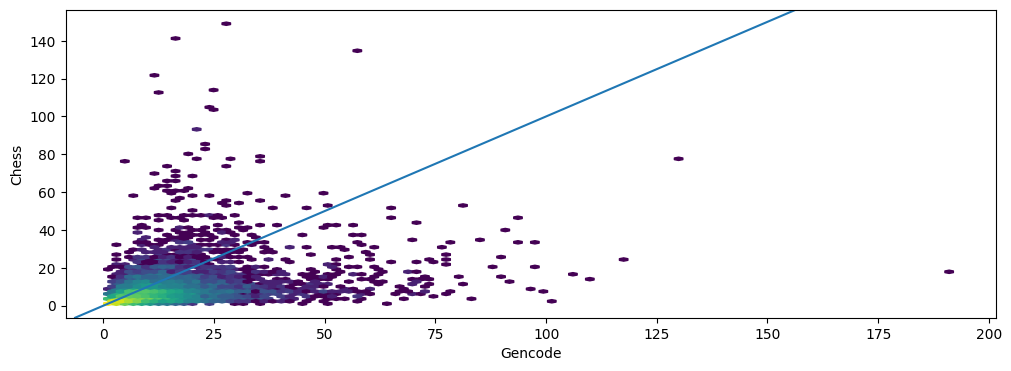

In [9]:
# calculate vectors of pairwise transcript counts for all shared gene_names
x, y = zip(*[(len(t_gc[gn].transcript), len(t_ch[gn].transcript) ) for gn in shared ])
# scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.hexbin(x,y, bins='log')
ax.axline((1, 1), slope=1)
plt.xlabel('Gencode')
plt.ylabel('Chess')
# correlation coefficient
display(f'R_pearson={np.corrcoef(x,y)[0,1]}')

We can observe large differences between the compared annotation set. Let's
look at the most extreme example.

In [10]:
max_diff_idx = np.argmax(np.array([abs(a-b) for a,b in zip(x,y)]))
max_diff_gene = list(shared)[max_diff_idx]
display(f"The gene with the largest difference in annotated transcripts is {t_gc.gene[max_diff_gene].gene_name}")

tr_gc, tr_ch = t_gc.gene[max_diff_gene].transcript, t_ch.gene[max_diff_gene].transcript
display(f"In gencode, there are {len(tr_gc)} tx, in chess, there are {len(tr_ch)}")
display_textarea(f"gencode tx: {tr_gc}")
display_textarea(f"chess tx: {tr_ch}")

'The gene with the largest difference in annotated transcripts is MAPK10'

'In gencode, there are 192 tx, in chess, there are 18'

In a final analysis, we want to count the number of introns with canonical splice sites, i.e.,
having GT and AG at either end of that intron. For this, we must load gene sequences and in this
example we do this only for chr20. 

First, we instantiate 2 new transcriptomes that use the same configuration as before but now add the grch38_chr20 
reference sequence and load those sequences at startup. Note that rnalib detects that the referenced genome contains
only chr20 and will merge the respective refdicts resulting in only genes/transcripts located on chr20 being loaded.

In [11]:
t_gc_chr20=rna.Transcriptome(
    annotation_gff = gencode_gff,
    annotation_flavour ='gencode',
    genome_fa = rna.get_resource("grch38_chr20"), # GRCh38 chr20 reference sequence
    load_sequence_data=True,
    copied_fields =['gene_type', 'transcript_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

t_ch_chr20=rna.Transcriptome(
    annotation_gff = chess_gff,
    annotation_flavour ='chess',
    genome_fa = rna.get_resource("grch38_chr20"), # GRCh38 chr20 reference sequence
    load_sequence_data=True,
    copied_fields =['gene_type'],
    gene_name_alias_file = alias_txt,
    feature_filter = txfilter)

# show merged refdicts and numbers of loaded genes/transcripts
display(SEP)
display(t_gc_chr20, t_gc_chr20.merged_refdict)
display(t_ch_chr20, t_ch_chr20.merged_refdict)

load gene aliases:   0%|          | 0/43842 [00:00<?, ?it/s]

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Load sequences:   0%|          | 0/546 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/546 [00:00<?, ?it/s]

load gene aliases:   0%|          | 0/43842 [00:00<?, ?it/s]

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Load sequences:   0%|          | 0/1479 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/1479 [00:00<?, ?it/s]

---

Transcriptome with 546 genes and 3629 tx (+seq)

RefDict (size: 1): dict_keys(['chr20']), dict_values([64444167]) name: References from FASTA file b'rnalib_testdata//bigfiles/grch38_chr20.fa.gz',References from TABIX file b'rnalib_testdata//bigfiles/gencode_39.gff3.gz' 

Transcriptome with 1479 genes and 4024 tx (+seq)

RefDict (size: 1): dict_keys(['chr20']), dict_values([64444167]) name: References from FASTA file b'rnalib_testdata//bigfiles/grch38_chr20.fa.gz',References from TABIX file b'rnalib_testdata//bigfiles/chess3.0.1.gtf.gz' 

,annotation,SJ,count
17,chess,GT/AG,25657
0,gencode,GT/AG,25395
1,gencode,GC/AG,216
18,chess,GC/AG,208
5,gencode,AT/AC,31


'In gencode, we found 98.86708712917542% canonical splice sites'

'In chess,   we found 98.98533950617285% canonical splice sites'

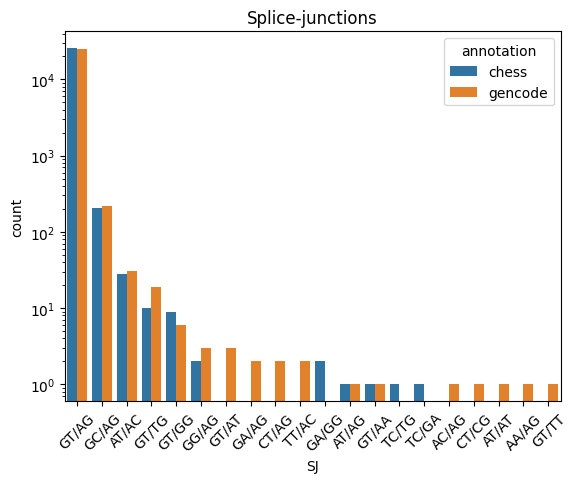

In [12]:
# now, lets count introns with and without consensus dinucleotides (GT and AG) 
# at either end of that intron
stats = defaultdict(Counter)
for name, tr in [('gencode',t_gc_chr20),('chess', t_ch_chr20)]:
    for intron, _ in tr.iterator(feature_types='intron'):
        if len(intron)<4: # skip very short introns
            continue
        a,b = intron.sequence[:2].upper(), intron.sequence[-2:].upper()
        if intron.strand=='-': # reverse complement for minus strand genes
            a,b = rna.reverse_complement(b), rna.reverse_complement(a)
        stats[name][f'{a}/{b}'] += 1
# convert to dataframe
df = pd.DataFrame.from_records([(n,t,c) for n in stats for t,c in stats[n].items()], 
                               columns=['annotation', 'SJ', 'count']).sort_values(['count'], ascending=False)
display(df.head())

# Show % canonical SJ
# compare: PMID: 11058137: 98.71% canonical, 0.56% non-canonical GC-AG
display(f"In gencode, we found {stats['gencode']['GT/AG'] / stats['gencode'].total() * 100}% canonical splice sites")
display(f"In chess,   we found {stats['chess']['GT/AG'] / stats['chess'].total() * 100}% canonical splice sites")

# plot results
sns.barplot(x='SJ', y='count', data=df, hue='annotation')
_= plt.xticks(rotation=45)
_= plt.yscale("log")
_= plt.title("Splice-junctions")

So, gencode shows more non-canonical splice junctions that are possibly wrong.

Another quality control step is to check whether the lengths of CDS annotations are divisible by three which indicates a proper reading frame. 
Here, we count the remainder of a division by 3 of annotated CDS lengths per transcript (len(CDS) mod 3), put the data in a pandas dataframe and plot with seaborn.

'In gencode, we found 88.02209286781951% CDS annotation that are divisible by 3'

'In Chess, we found 99.552077336252% CDS annotation that are divisible by 3'

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


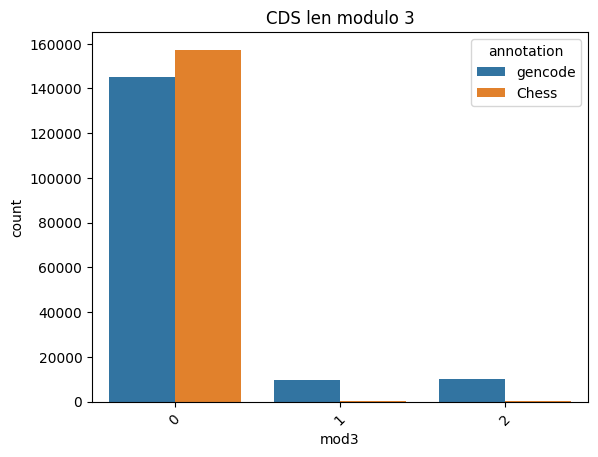

In [13]:
dfs=list()
stats={}
for t_name, trans in (('gencode',t_gc), ('Chess', t_ch)):
    # sum up the lengths of CDS annotations per transcript and count
    cnt = Counter([sum([len(cds) for cds in tx.CDS ])%3 for tx in trans.transcripts ])
    # convert to a dataframe
    df = pd.DataFrame.from_records(list(dict(cnt).items()), columns=['mod3','count'])
    # add column with annotation name
    df['annotation'] = t_name
    # add to list of dataframes that is then concatenated for plotting
    dfs.append(df)
    # calc % of mod==0 annotations
    display(f"In {t_name}, we found {cnt[0]/cnt.total() * 100}% CDS annotation that are divisible by 3")
# plot the data
sns.barplot(x='mod3', y='count', data=pd.concat(dfs), hue='annotation')
_= plt.xticks(rotation=45)
#_= plt.yscale("log")
_= plt.title("CDS len modulo 3")


Again, gencode seems to contain more 'wrong' or incomplete annotations.

## Part 2: comparison of miRNA annotations in mirgendb and flybase

In this second example, we compare microRNA annotations in flybase and MirGenDB, a curated and validated microRNA database.
To do so, we

* instantiate two transcriptomes from mirgendb and flybase
* map the annotations by (i) matching annotated locations and (ii) by overlap of annnotated locations
* We show that all but one mirgendb are contained in flybase, although with slightly diverging coordinates
* The missing miRNA is annotated as hpRNA (haipin RNA) in flybase.
* Flybase contains a lot more (posssibly false-positive) miRNA annotations


First, we build a transcriptome from mirgendb annotations and create a dict that maps transcripts to gene names (miRNA ids) for 
mature miRNAs only. Please note, that we lose 2 miRNA annotations with non-unique location here but we ignore for now

In [14]:
t_mg = rna.Transcriptome(
    annotation_gff = rna.get_resource("mirgendb_dme_gff"), # mirgendb data,
    annotation_flavour ='mirgenedb')

# create a dict that maps transcripts to gene names (miRNA ids) for mature miRNAs only
# NOTE that we lose 2 miRNA annotations with non-unique location here but we ignore for now
t_mg_mir = {tx.location: tx.feature_id  for tx in t_mg.transcripts if tx.gff_feature_type=='miRNA'} # get all fb miRNAs
rna.head_counter(t_mg_mir) # show some data

Building transcriptome (5 chromosomes)
:   0%|          | 0/5 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/483 [00:00<?, ?it/s]

Counter({2L:243096-243118 (-): 'Dme-Mir-965_5p*',
         2L:5641081-5641102 (+): 'Dme-Mir-960_5p',
         2L:5641119-5641140 (+): 'Dme-Mir-960_3p*',
         2L:5640959-5640980 (+): 'Dme-Mir-959-v2_5p*',
         2L:5640999-5641020 (+): 'Dme-Mir-959-v2_3p',
         2L:5640958-5640979 (+): 'Dme-Mir-959-v1_5p*',
         2L:5641000-5641021 (+): 'Dme-Mir-959-v1_3p',
         2L:857556-857579 (+): 'Dme-Mir-375_5p*',
         2L:857596-857617 (+): 'Dme-Mir-375_3p'})

The full flybase gene annotation GTF file is not part of the rnalib test suite. Here, we download it to a temporary directory, 
use the `create_testdata()` method to sort+index and then load the transcriptome.

Note that this works only if you have the following tools installed: bgzip, bedtools, tabix

In [15]:
with tempfile.TemporaryDirectory() as tmpdir:
    res = {"flybase_full": {
            "uri": "https://ftp.flybase.net/releases/FB2023_06/dmel_r6.55/gtf/dmel-all-r6.55.gtf.gz",
            "filename": "dmel-all-r6.55.gtf.gz"}}
    rna.testdata.create_testdata(tmpdir, res) # download, sort + index; needs bgzip, bedtools, tabix
    t_fb = rna.Transcriptome(
        annotation_gff = rna.get_resource("flybase_full", tmpdir, res), 
        annotation_flavour ='flybase')

# create a dict that maps transcripts to gene names (miRNA ids) for mature miRNAs only
t_fb_mir = { tx.location: tx.feature_id for tx in t_fb.transcripts if tx.gff_feature_type=='miRNA'} # get all fb miRNAs
rna.head_counter(t_fb_mir) # show some data

Creating testdata:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/17872 [00:00<?, ?it/s]

Counter({2L:243096-243118 (-): 'FBtr0472777',
         2L:857556-857579 (+): 'FBtr0472769',
         2L:2737568-2737589 (+): 'FBtr0309710',
         2L:3463362-3463383 (-): 'FBtr0309607',
         2L:3636992-3637013 (-): 'FBtr0309600',
         2L:3637028-3637049 (-): 'FBtr0309599',
         2L:1831710-1831731 (-): 'FBtr0304393',
         2L:1831749-1831770 (-): 'FBtr0304392',
         2L:857596-857617 (+): 'FBtr0304183'})

Now, we two dicts containing miRNA intervals from both annotations and can start to compare them...

In [16]:
display(f"annotated miRNAs in mirgendb: {len(t_mg_mir)}, in flybase: {len(t_fb_mir)}")

'annotated miRNAs in mirgendb: 320, in flybase: 485'

First, we create a very simple mappping by matching exact coordinates between the two annotations.
We show the results and count for how many flybase miRNA annotations we could find an exact match in mirgendb.

In [17]:
mapping={name:t_mg_mir.get(mir, None) for mir,name in t_fb_mir.items()}
display_textarea(mapping)
display(Counter(['no exact mapping' if v is None else 'exact_mapping' for v in mapping.values()]))

Counter({'no exact mapping': 270, 'exact_mapping': 215})

Now, we create a second mapping based on interval overlap by using an AnnotationIterator. 
This iterator will iterate all intervals from the wrapped iterator (here: the flybase miRNAs) and annotate them with all overlapping intervals from the 
anno_its (here: all mirgendb miRNA intervals). 

In [18]:
mapping2={}
# The following code will create two MemoryIterators that iterate the intervals in t_fb_mir and t_mg_mir and a AnnotationIterator that 
# annotates the first with all intervals of the second. The iterator types are propery guessed by the rna.it() factory method.
with rna.it( rna.it(t_fb_mir),  anno_its=rna.it(t_mg_mir)) as it:
    for loc, (fb_mir, mg_mir) in it:
        mapping2[fb_mir] = [x.data for x in mg_mir]
        #display(f"{loc}, {fb_mir}, {mg_mir}")
display_textarea(mapping2)    
display(Counter(['no overlap mapping' if len(v)==0 else 'overlap_mapping' for v in mapping2.values()]))

  0%|          | 0/7 [00:00<?, ?it/s]

Counter({'overlap_mapping': 278, 'no overlap mapping': 207})

Here, we count the newly found mappings and assert that we have not lost any...

In [19]:
display(Counter(['new mappings' for x in mapping if mapping[x] is None and len(mapping2[x])>0]))
assert Counter(['missed mappings' for x in mapping if mapping[x] is not None and len(mapping2[x])==0])['missed mappings']==0

Counter({'new mappings': 63})

Let's print the names of some missed miRNAs...

In [20]:
missed_fb_mir_names = [t_fb[tid].parent.gene_name for tid, mg_tids in mapping2.items() if len(mg_tids)==0]
display(f'some missed names: {missed_fb_mir_names[:10]}')

"some missed names: ['mir-2280', 'mir-2280', 'mir-4914', 'mir-4971', 'mir-4972', 'mir-4972', 'mir-1004', 'mir-1004', 'mir-1005', 'mir-4910']"

Now, we do the reverse mapping, i.e., we look at all mirgendb entries and try to map to flybase...

In [21]:
mapping3={}
# Try to map by overlap with annotation iterator
with rna.AnnotationIterator(
    rna.MemoryIterator(t_mg_mir),
    rna.MemoryIterator(t_fb_mir)) as it:
    for loc, (mg_mir, fb_mir) in it:
        mapping3[mg_mir] = [x.data for x in fb_mir]
display_textarea(mapping3)    
display(Counter(['no overlap mapping' if len(v)==0 else 'overlap_mapping' for v in mapping3.values()]))

  0%|          | 0/5 [00:00<?, ?it/s]

Counter({'overlap_mapping': 318, 'no overlap mapping': 2})

As we can see, only two mirgendb miRNAs are not found in the flybase annotation. Let's print ids and names of those:

In [22]:
missed_mg_mir_ids = [t_mg[tid].parent.gene_name for tid, fb_tids in mapping3.items() if len(fb_tids)==0]
display(f'missed ids: {missed_mg_mir_ids} with names {[t_mg[gn].feature_id for gn in missed_mg_mir_ids]}')

"missed ids: ['MIMAT0020897', 'MIMAT0005517'] with names ['gene_Dme-Mir-997_3p*', 'gene_Dme-Mir-997_5p']"

So, we are missing mir997 mature miRNA annotations in flybase. Let's query the flybase transcriptome for the respective mirgendb pre-miRNA annotation:

In [23]:
display('gene_Dme-Mir-997_pre overlapping fb transcripts:', 
        [(tx.feature_id, tx.parent.gene_name) for tx in t_fb.query(t_mg['gene_Dme-Mir-997_pre'], 'transcript')])

'gene_Dme-Mir-997_pre overlapping fb transcripts:'

[('FBtr0345277', 'lncRNA:CR44175'),
 ('FBtr0336792', 'lncRNA:CR44175'),
 ('FBtr0336791', 'lncRNA:CR44175'),
 ('FBtr0472838', 'hpRNA:CR46343')]

We can see that there is a hairpin RNA (hpRNA) annotation overlapping with the respective mirgendb annotation.
We can also visualize this region IGV. Here, we first create a temporary BED file containing the flybase hpRNA and the two miRNA
annotations from mirgendb and then load this file into IGV:

In [24]:
with tempfile.TemporaryDirectory(dir=rna.__RNALIB_TESTDATA__) as tmpdir:
    bed_file = f"{tmpdir}/test.bed"
    with open(bed_file, 'wt') as out:
        # iterate over a dict with name:GI entries (will instantiate a MemoryIterator), convert to 
        # the BED format and write to the temporary file
        rna.it({ 'hpRNA:CR46343': t_fb['hpRNA:CR46343'], 
             'gene_Dme-Mir-997_3p*': t_mg['gene_Dme-Mir-997_3p*'],  
             'gene_Dme-Mir-997_5p': t_mg['gene_Dme-Mir-997_5p']}).to_bed(out)
    # calculate notebook-relative path to make this work in jupyter lab
    bed_file_rel = os.path.relpath(bed_file, pathlib.Path(os.path.abspath(rna.__RNALIB_TESTDATA__)).parent)
    # create IGV browser, see https://github.com/igvteam/igv.js/wiki/Alignment-Track
    import igv_notebook, time
    igv_notebook.init() 
    igv_browser = igv_notebook.Browser( # configure a browser
    {
        "genome": "dm6",
        "tracks": [{ "name":     "BED", 
                     "url":      bed_file_rel,
                     "format":   "bed",
                     "displayMode": "EXPANDED"}]
    }).search('hpRNA:CR46343') # go to hpRNA location
    for i in tqdm(range(3), desc='Timeout for tempdir', bar_format='{l_bar}{bar}{postfix}'):
        time.sleep(1) # keep temp dir alive and show remaining time
    rna.display_popover('Tempdir deleted! You can still view the currently loaded data in IGV but cannot load additional resources', clear=False)
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Timeout for tempdir:   0%|          

<IPython.core.display.Javascript object>

We provided the dm6 genome to IGV and here we can see (in the RefSeq) track (you may have to scroll down) that there is a mir-997-1 annotation with the same coordinates as 
the hpRNA we found in the dmel GTF file. This is due to a (potential) incosistency in the flybase annotation files. 
The GTF we downloaded above (dmel-all-r6.55.gtf) does not contain this annotation while the corresponding GFF (dmel-all-r6.55.gff.gz) does and annotates the following names 
for this gene (FBgn0285993):

* Name=hpRNA:CR46343
* fullname=hairpin RNA:CR46343;Alias=FBgn0262262,CR42969,FBgn0285968,CR42969,miR-997,miR997,miR-997-1,mir-997-1,dme-mir-997-1,mir-997 stem loop,mir-997,mir-997-1 stem loop,hp-mir-997-1,CR46343,dme-miR-997,dme-mir-997

## Summary

This concludes our gene set comparison tutorial. This tutorial demonstrated:
* load filtered versions of large transcriptomes, annotated using different GFF flavours
* normalise gene symbols to the latest version using gennames.org data
* deal with duplicate gene names (e.g., in PAR regions)
* systematically compare annotation sets based on gene names, transcript coordinates, etc.
* compare splice-junction dinucleotides and CDS lengths
* map annotations based on coordinate overlap
